In [1]:
import xarray as xr
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
import warnings
from sklearn.metrics import mean_absolute_error
import matplotlib as mpl

pd.set_option('display.max_columns', None)
# Suppress all warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import seaborn as sns

from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, BboxTransformTo
from matplotlib.transforms import Bbox

In [3]:
# Example colormaps
cmap1 = plt.cm.Blues
cmap2 = plt.cm.plasma
cmap3 = plt.cm.plasma

colors1 = cmap1(np.linspace(0.01, 1,250))
colors2 = cmap2(np.linspace(0.2, 1, 400))
colors3 = cmap3(np.linspace(0.8, 1, 100))

colors = np.vstack((colors1, colors2))

colors_pd = pd.DataFrame(colors)
colors_pd = colors_pd.rolling(window = 250, min_periods = 1).mean()
x = colors_pd.values
colors = np.vstack((colors_pd.values, colors3))
colors_pd = pd.DataFrame(colors)
colors_pd = colors_pd.rolling(window = 50, min_periods = 1).mean()
x = colors_pd.values
# colors3 = colors_pd.values

blended_cmap = LinearSegmentedColormap.from_list('blended_cmap', x)

In [23]:
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/OUTPUT/testing_output/predictions_s1_xg_100.p', 'rb') as fp:
    pred_s100 = pickle.load(fp) 
    
pred_s100.loc[((pred_s100.sc_percum<0.25)), 'prediction_label']=0
pred_s100.loc[pred_s100.prediction_label<0, 'prediction_label']=0
pred_s100= pred_s100[(pred_s1.sd_insitu>0.0)]
#all_data = all_data.dropna(how = 'all')

In [28]:
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/OUTPUT/testing_output/predictions_s1_xg.p', 'rb') as fp:
    pred_s1 = pickle.load(fp) 
    
pred_s1.loc[((pred_s1.sc_percum<0.25)), 'prediction_label']=0
pred_s1.loc[pred_s1.prediction_label<0, 'prediction_label']=0
pred_s12= pred_s1[(pred_s1.sd_insitu>0.0)]
pred_s12 = pred_s12[~np.isnan(pred_s12.site)].dropna()

In [25]:
def prepare_panel(ax, label1, label2):
    ax.plot([0,6],[0,6], 'k-', alpha = 0.75)
#ax[0].plot(np.arange(0,7),np.arange(0,7)*ml.slope+ml.intercept, 'r--')
    ax.set_xlabel(label1, fontsize = 22)
    ax.set_ylabel(label1, fontsize = 22)
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([0,1,2,3,4,5,6])
    ax.set_xticklabels([0,1,2,3,4,5,6], fontsize = 18)
    ax.set_yticklabels([0,1,2,3,4,5,6], fontsize = 18)
    ax.grid()

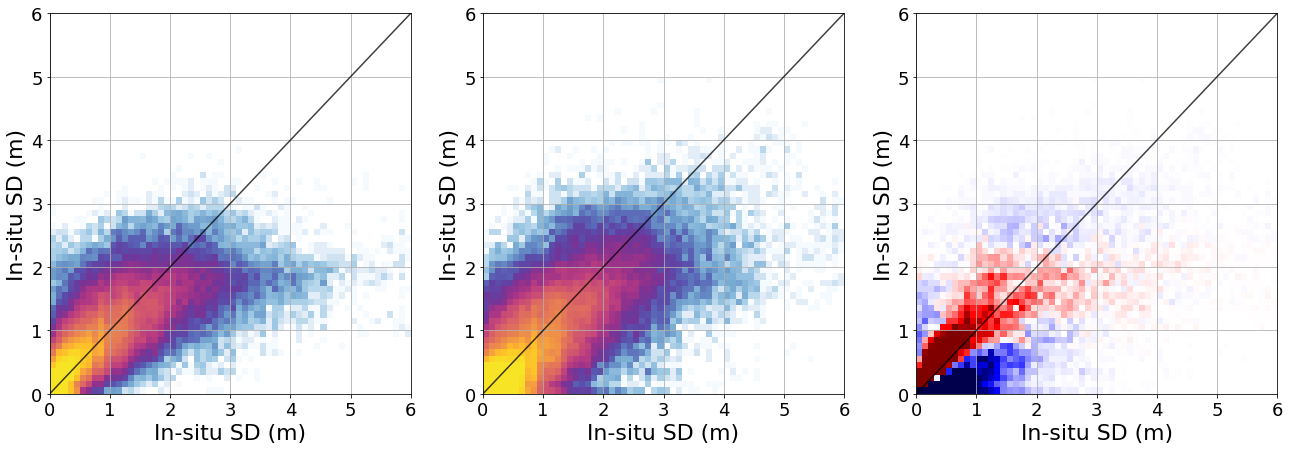

In [30]:
data = pred_s12#[pred_s12.sd_insitu>4]

hans = stats.linregress(data.sd_insitu.values, data.sd_hans.values)
ml = stats.linregress(pred_s100.sd_insitu.values, pred_s100.prediction_label.values)
    
ml_MAE = mean_absolute_error(pred_s100.sd_insitu.values, pred_s100.prediction_label)
hans_MAE = mean_absolute_error(data.sd_insitu.values, data.sd_hans.values)    
    
bins = np.arange(0,6.1,0.1)  
fig, ax = plt.subplots(1,3,figsize = (22,7))
    
im1 = ax[0].hist2d( pred_s100.sd_insitu.values, pred_s100.prediction_label, bins=bins, cmap=blended_cmap, range=[[0, 6], [0, 6]], norm=LogNorm(vmin=1, vmax=1e3))
prepare_panel(ax[0],'In-situ SD (m)','ML SD (m)')

im1 = ax[1].hist2d(data.sd_insitu.values, data.sd_hans.values, bins=bins, cmap=blended_cmap, range=[[0, 6], [0, 6]], norm=LogNorm(vmin=1, vmax=1e3))
prepare_panel(ax[1],'In-situ SD (m)','Change detection SD (m)')

(counts_hans, _, _) = np.histogram2d(data.sd_insitu, data.sd_hans, bins=bins)
(counts_ml, _, _) = np.histogram2d(data.sd_insitu, data.prediction_label, bins=bins)
diff = (counts_ml - counts_hans).transpose()
diff[diff==0] = np.nan
ax[2].pcolormesh(bins, bins, diff,cmap='seismic', vmin = -200, vmax = 200)
prepare_panel(ax[2],'In-situ SD (m)','Predicted SD (m)')


#plt.savefig('Fig1panels/Figure1b_c.png', dpi = 300, bbox_inches = 'tight')




In [22]:
#print(ml1)
print(ml)
#print(hans)


def rmse_fun(o, p):
    """Calculate the root mean squared error between predictions and targets"""
    return np.sqrt(np.mean((p - o) ** 2))

#print(rmse_fun(all_pred1.prediction_label, all_pred1.sd_insitu))
#print(rmse_fun(all_pred2.prediction_label, all_pred2.sd_insitu))
print(rmse_fun(pred_s1.prediction_label, pred_s1.sd_insitu))
#print(rmse_fun(pred_s1.sd_hans, pred_s1.sd_insitu))

print(np.abs((data.prediction_label - data.sd_insitu)).mean())
#print(np.abs((data.sd_hans - data.sd_insitu)).mean())

LinregressResult(slope=0.5823178450810285, intercept=0.31382150237356976, rvalue=0.7427792367830243, pvalue=0.0, stderr=0.0014432412795190594, intercept_stderr=0.0016535124824194891)
0.47045496
0.36177644


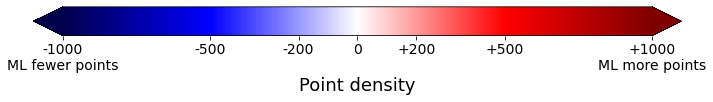

In [13]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='seismic', extend = 'both')
cb.set_ticks([0,0.25, 0.4,0.5, 0.6,0.75, 1])
cb.set_ticklabels(['-1000\nML fewer points',-500,-200,0,'+200','+500','+1000\nML more points'], fontsize = 14)
cb.set_label('Point density', fontsize = 18)
plt.savefig('Fig1panels/ml_hans_diff_colorbar.png', bbox_inches='tight', transparent = True, dpi = 300)

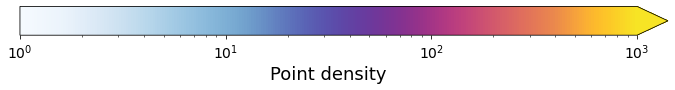

In [14]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=blended_cmap, extend = 'max', norm=LogNorm(vmin=1, vmax=1e3))
cb.set_label('Point density', fontsize = 18)
cb.set_ticks([1,10,100,1000])
cb.set_ticklabels(['$10^0$','$10^1$','$10^2$','$10^3$'], fontsize = 14)
cb.set_label('Point density', fontsize = 18)
plt.savefig('Fig1panels/hist2d_colorbar.png', bbox_inches='tight', transparent = True, dpi = 300)

In [15]:
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/training_testing/training_data.p', 'rb') as fp:
    d = pickle.load(fp)

# find max sd_date
md = list()
for i, row in d.iterrows():
    md.append(row.time.strftime('%m-%d'))

d['MD'] = md
pred_time = d.groupby(d.MD).mean()#.rolling(window =7, center = True).mean()

new_year = pred_time.iloc[0:152]
old_year = pred_time.iloc[152:]
together = pd.concat([old_year, new_year]).dropna()
together = together.rolling(window =7, center = True).mean()


In [16]:
together[together.sd_insitu == together.sd_insitu.max()]
together[together.sd_hans == together.sd_hans.max()]


,site,lat,lon,sd_insitu,sd_hans,wet_hans,ims,sc_cum,sc_per,sc_percum,elevation,slope,aspect,tpi,fcf,landcover,snowclass,vv,vh,cr,vv_scaled,vh_scaled,cr_scaled,lia,orbit,ad,satellite,fold,DayOfSeason
MD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
03-08,474.938305,46.46807,9.594613,0.813482,0.721847,0.592714,0.779584,76.167171,0.623998,58.485951,1447.16687,10.353752,185.99016,-0.568622,13.332755,56.323623,3.863938,-8.546713,-15.900615,-7.353902,0.516011,0.496631,0.220825,38.660494,86.39895,1.5004,1.442564,3.007828,219.25606


In [17]:
md = list()
for i, row in data.iterrows():
    md.append(row.time.strftime('%m-%d'))
data['MD'] = md
pred_time = data.groupby(data.MD).mean()#.rolling(window =7, center = True).mean()
n = data.groupby(data.MD).count()#.rolling(window =7, center = True).mean()

new_year = pred_time.iloc[0:152]
old_year = pred_time.iloc[152:]
together = pd.concat([old_year, new_year]).dropna()
together = together.rolling(window =7, center = True).mean()

n1 = n.iloc[0:152]
n2 = n.iloc[152:]
n3 = pd.concat([n2, n1]).dropna()
n3 = n3.rolling(window =7, center = True).mean()

In [18]:
ml_bias = data.prediction_label - data.sd_insitu
ml_bias_dos = ml_bias.groupby(data.DayOfSeason).mean()
ml_bias_dos_std = ml_bias.groupby(data.DayOfSeason).std()

hans_bias = data.sd_hans - data.sd_insitu
hans_bias_dos = hans_bias.groupby(data.DayOfSeason).mean()
hans_bias_dos_std = hans_bias.groupby(data.DayOfSeason).std()


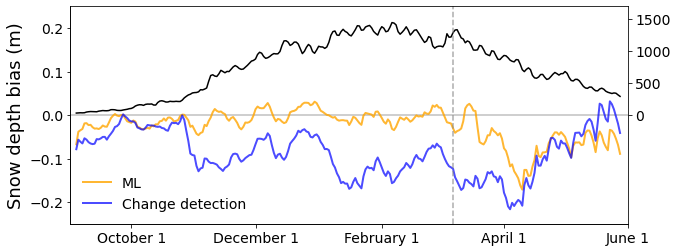

In [19]:

fig, ax = plt.subplots(1,1,figsize = (10,4))
ax.plot([0,360],[0,0], color = 'grey', alpha = 0.5)
ax.plot(together.index, together.prediction_label - together.sd_insitu, color = 'orange',alpha = 0.8, label = 'ML', linewidth = 2)
ax.plot(together.index, together.sd_hans - together.sd_insitu, color = 'blue', alpha = 0.7, label = 'Change detection', linewidth = 2)
ax2 = ax.twinx()
ax2.plot(n3.index, n3.site, 'k', label = '# Obs.')

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(['09-01','06-01'])
ax.set_xticks(['10-01', '12-01', '02-01','04-01', '06-01'])
ax.set_xticklabels(['October 1', 'December 1', 'February 1', 'April 1', 'June 1'], fontsize = 14)
ax.set_ylabel('Snow depth bias (m)', fontsize = 18)
ax.set_ylim([-0.25, 0.25])
ax2.set_ylim([-1700, 1700])
ax2.set_yticks([0,500,1000,1500])
ax2.set_yticklabels([0,500,1000,1500], fontsize = 14)
ax2.plot([188,188], [-1700,1700], '--',color = 'grey', alpha = 0.65)
#ax2.set_ylabel('# Observations', fontsize =18)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc = 'lower left', fontsize = 14, frameon = False)
plt.savefig('Fig1panels/Figure1d.png', dpi = 300, bbox_inches = 'tight')
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

In [20]:
early_season = together['09-01':'11-01']
print('early season ML', (early_season.prediction_label - early_season.sd_insitu).mean())
print('early season hans', (early_season.sd_hans - early_season.sd_insitu).mean())
may = together['04-01':'05-31']
print('may bias ML', (may.prediction_label - may.sd_insitu).mean())
print('max hans bias', (together.sd_hans - together.sd_insitu).min())
peak = together['03-08':'03-09']
print('peak ML bias', (peak.prediction_label - peak.sd_insitu).mean())
print('peak hans bias', (peak.sd_hans - peak.sd_insitu).mean())

early season ML -0.01877288122099912
early season hans -0.037012664522281136
may bias ML -0.07842717264673395
max hans bias -0.21652446474347797
peak ML bias -0.03882620164326256
peak hans bias -0.1476586844239916


In [21]:
elevation = xr.open_dataset('/staging/leuven/stg_00024/OUTPUT/devond/Microwave_practical/elevation.nc')
background = np.zeros(elevation.Elevation_inst.values.shape)

In [22]:
site_ml_bias = (data.groupby(data.site).mean().prediction_label - data.groupby(data.site).mean().sd_insitu)
site_hans_bias = data.groupby(data.site).mean().sd_hans - data.groupby(data.site).mean().sd_insitu

site_ml_bias.loc[data.groupby(data.site).count().time<50] = np.nan
site_hans_bias.loc[data.groupby(data.site).count().time<50] = np.nan

sites = data.groupby(data.site).mean()
#print(np.abs((sites.prediction_label - sites.sd_insitu)).mean())
#print(np.abs((sites.sd_hans - sites.sd_insitu)).mean())

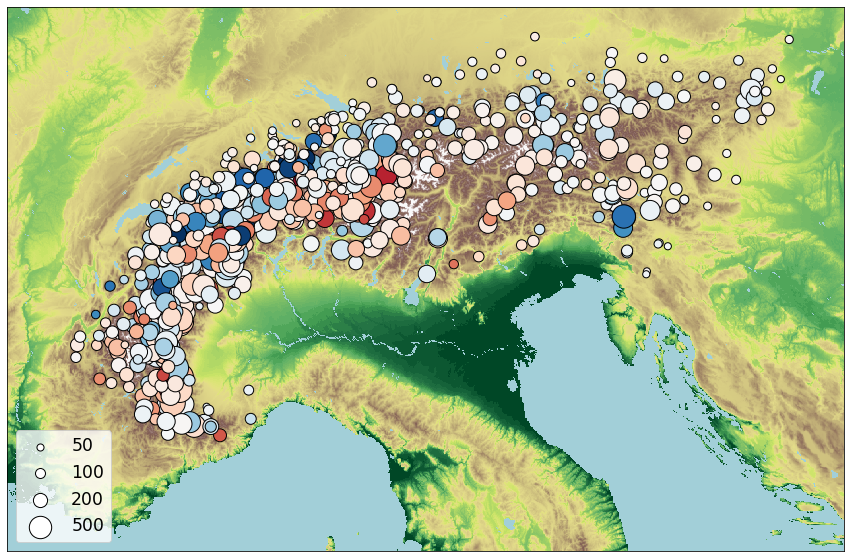

In [23]:
# Example colormaps
cmap1 = plt.cm.ocean_r
cmap2 = plt.cm.summer
cmap3 = plt.cm.terrain

colors1 = cmap1(np.linspace(0.7, 1,10))
colors2 = cmap2(np.linspace(0.25, 0.9, 50))
colors3 = cmap3(np.linspace(0.55, 0.8, 400))
colors4 = cmap3(np.linspace(0.8, 1, 100))
colors = np.vstack((colors1, colors2, colors3, colors4))

x = pd.DataFrame(colors)
x = x.rolling(window = 20, min_periods = 1, center = True).mean()
colors3 = x.values

blended_cmap = LinearSegmentedColormap.from_list('blended_cmap', colors3)

fig, ax = plt.subplots(1,1,figsize = (15,10))
ax.pcolormesh(elevation.lon, elevation.lat, background, cmap = 'Spectral', vmin = -150, vmax = 25, alpha = 0.5)
im1 = ax.pcolormesh(elevation.lon, elevation.lat, elevation.Elevation_inst, cmap = blended_cmap, vmin = -0, vmax = 3000)
im2 = ax.scatter(sites.lon, sites.lat, c = site_ml_bias, cmap = 'RdBu_r', edgecolors = 'k', s = data.groupby(data.site).count().time, vmin = -1, vmax = 1)
ax.scatter([-1],[-1], c = 'white', s = 50, edgecolors = 'k', label = '50')
ax.scatter([-1],[-1], c = 'white', s = 100, edgecolors = 'k', label = '100')
ax.scatter([-1],[-1], c = 'white', s = 200, edgecolors = 'k', label = '200')

ax.scatter([-1],[-1], c = 'white', s = 500, edgecolors = 'k', label = '500')
lg = plt.legend(frameon = True, loc = 'lower left', title = '', fontsize='xx-large')
#lg.set_title('# Observations', fontsize = 20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([4.505, 17.19])
ax.set_ylim([42.85,  48.59])
plt.savefig('Fig1panels/Figure1_a.png', dpi = 300, bbox_inches = 'tight')


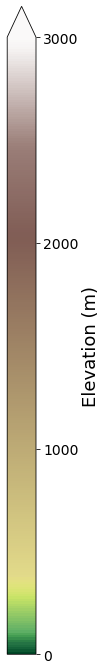

In [24]:


fig = plt.figure(figsize = (4,10))
ax = fig.add_axes([0.8, 0.05, 0.1, 0.9])

cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical', 
                               cmap=blended_cmap, extend = 'max')

cb.set_ticks([0,1/3,2/3,1])
cb.set_ticklabels([0,1000,2000,3000], fontsize = 14)
cb.set_label('Elevation (m)', fontsize = 18)
plt.savefig('Fig1panels/elevation_colormap.png', dpi = 300, bbox_inches = 'tight', transparent = True)

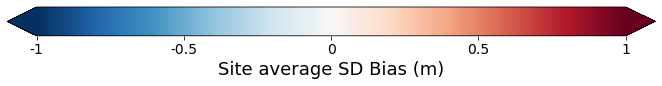

In [25]:


fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.05, 0.8, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='RdBu_r', extend = 'both')

cb.set_ticks([0,0.25,0.5,0.75,1])
cb.set_ticklabels([-1,-0.5,0,0.5,1], fontsize = 14)
cb.set_label('Site average SD Bias (m)', fontsize = 18)
plt.savefig('Fig1panels/SD_bias_colormap.png', dpi = 300, bbox_inches = 'tight', transparent = True)


In [33]:
x = pred_s12.groupby(pred_s12.site).mean()
c = pred_s12.groupby(pred_s12.site).count().lat

x = x[c>50]
ml_site_bias = x.prediction_label - x.sd_insitu
hans_site_bias = x.sd_hans - x.sd_insitu

ml_site_rbias = np.abs((x.prediction_label - x.sd_insitu)/x.sd_insitu)
hans_site_rbias = np.abs((x.sd_hans - x.sd_insitu)/x.sd_insitu)

In [36]:
print(f'{len(x)} sites with more than 50 measurements')
print(f'{len(ml_site_bias[ml_site_bias>0.5])} sites with ML bias > 0.5')
print(f'{len(ml_site_bias[hans_site_bias>0.5])} sites with hans bias > 0.5')
print(f'{len(ml_site_bias[ml_site_bias<-0.5])} sites with ML bias < -0.5')
print(f'{len(ml_site_bias[hans_site_bias<-0.5])} sites with hans bias < -0.5')

print(f'{len(ml_site_bias[ml_site_bias>0.2])} sites with ML bias > 0.2')
print(f'{len(ml_site_bias[hans_site_bias>0.2])} sites with hans bias > 0.2')
print(f'{len(ml_site_bias[ml_site_bias<-0.2])} sites with ML bias < -0.2')
print(f'{len(ml_site_bias[hans_site_bias<-0.2])} sites with hans bias < -0.2')

#print(f'{len(ml_site_bias[np.abs(ml_site_rbias)>2])}')
#print(f'{len(ml_site_bias[np.abs(hans_site_rbias)>2])}')

#ml_site_bias[ml_site_bias>0.5]

798 sites with more than 50 measurements
24 sites with ML bias > 0.5
18 sites with hans bias > 0.5
40 sites with ML bias < -0.5
62 sites with hans bias < -0.5
122 sites with ML bias > 0.2
86 sites with hans bias > 0.2
127 sites with ML bias < -0.2
210 sites with hans bias < -0.2


In [37]:
print(f'MAE ml: {np.abs(x.prediction_label - x.sd_insitu).mean()} m')
print(f'MAE hans: {np.abs(x.sd_hans - x.sd_insitu).mean()} m')
print(f'bias ml: {(x.prediction_label - x.sd_insitu).mean()} m')
print(f'bias hans: {(x.sd_hans - x.sd_insitu).mean()} m')

MAE ml: 0.18213066458702087 m
MAE hans: 0.21570241451263428 m
bias ml: -0.007667687255889177 m
bias hans: -0.09892282634973526 m


In [23]:
b_thresh1 = np.arange(-1,0,0.1)
ml_n, hans_n = list(), list() 
for b in b_thresh1:
    ml_n.append(len(ml_site_bias[ml_site_bias<b]))
    hans_n.append(len(hans_site_bias[hans_site_bias<b]))
    
b_thresh2 = np.arange(0,1.1,0.1)
ml_n2, hans_n2 = list(), list() 
for b in b_thresh2:
    ml_n2.append(len(ml_site_bias[ml_site_bias>b]))
    hans_n2.append(len(hans_site_bias[hans_site_bias>b]))

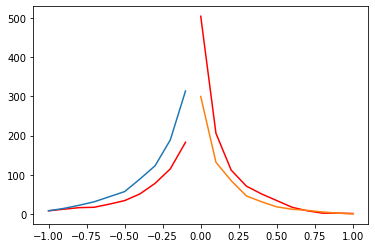

In [24]:
plt.plot(b_thresh1, ml_n, 'r')
plt.plot(b_thresh1, hans_n, )
plt.plot(b_thresh2, ml_n2, 'r')
plt.plot(b_thresh2, hans_n2)